# Homework #2 (Due 09/24/2020, 11:59pm)
## Bayesian versus Frequentist Inference

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:** Assaraf David

**Students collaborators:** Gael Ancel, Raphael Pellegrin

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. ***Portions of your submission that contains syntactic or run-time errors will not be graded***.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [1]:
### Import basic libraries
import numpy as np
import random
import pandas as pd
import sklearn as sk
from scipy.stats import multivariate_normal
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_posterior_samples(prior_var, noise_var, x_matrix, y_matrix, x_test_matrix, samples=100):
    '''Function to generate posterior predictive samples for Bayesian linear regression model'''
    prior_variance = np.diag(prior_var * np.ones(x_matrix.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)

    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_matrix)) / noise_var

    #sampling 100 points from the posterior
    posterior_samples = np.random.multivariate_normal(joint_mean.flatten(), joint_variance, size=samples)

    #take posterior predictive samples
    posterior_predictions = np.dot(posterior_samples, x_test_matrix.T) 
    posterior_predictive_samples = posterior_predictions[np.newaxis, :, :] + np.random.normal(0, noise_var**0.5, size=(100, posterior_predictions.shape[0], posterior_predictions.shape[1]))
    posterior_predictive_samples = posterior_predictive_samples.reshape((100 * posterior_predictions.shape[0], posterior_predictions.shape[1]))
    return posterior_predictions, posterior_predictive_samples


def generate_data(number_of_points=10, noise_variance=0.3):
    '''Function for generating toy regression data'''
    #training x
    x_train = np.hstack((np.linspace(-1, -0.5, number_of_points), np.linspace(0.5, 1, number_of_points)))
    #function relating x and y
    f = lambda x: 3 * x**3
    #y is equal to f(x) plus gaussian noise
    y_train = f(x_train) + np.random.normal(0, noise_variance**0.5, 2 * number_of_points)
    x_test = np.array(list(set(list(np.hstack((np.linspace(-1, 1, 200), x_train))))))
    x_test = np.sort(x_test)
    return x_train, y_train, x_test

## Part I: Maximum Likelihood Estimators for Polynomial Regression

In this problem, you are given a function, `generate_data`, to generate toy datasets with a single predictor $X$ and a single outcome $y$, and your task is to fit polynomial models to the data. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)
\end{align}

where the $w_d$, the *parameters* of the function $f$, are unknown constants, and the degree $D$ is a hyperparameter.


You'll notice that in these datasets, the test input is sampled from a different distribution that the training input: the training input has a gap, there are no training input values in [-0.5, 0.5], where as the test input are sampled across [-1, 1]. This change of the distributions over the $x$-values between training and test is called **covariate shift**.

These toy datasets simulate a very common problem in machine learning: models are fitted on training data, but during deployment they are given data dissimlar to the training data (i.e. the model encounters covariate shift). As such, you should treat `x_train`, `y_train` as data available during model development and evaluation, and `x_test` as data you encounter during model deployment. 

The goal in this assignment is to explore how to manage the risk of a deployed model under covariate shift. The ideas developed in this assignment will become a major focus in the latter part of the course and the foundation of an active area of current research.

1. **(Effect of Model Complexity)** Generate a toy dataset with 40 observations (set the parameter `number_of_points=20` for `generate_data`, since twice the number of `number_of_points` will be generated), then  visualize the fit of MLE polynomial models, with degrees $D = [1, 3, 5, 10, 15, 20, 50, 100]$ - you should train on `x_train` and **visualize by predicting on `x_test` provided by the data generating function (`x_test` is a larger set of test points that includes `x_train`)**. You'll need to be thoughtful about your visualization so that these different models can be visually compared in a meaningful way. <br><br>
Discuss the effect of the choice of polynomial degree on the fit of the model (concretely describe why certaint choices are unideal in the context of the problem).

In [3]:
x_train, y_train, x_test = generate_data(number_of_points=20)

Next, we are going to iterate over all the degrees considered and transform the training and testing data for every degree, in order to create polynomial features for polynomial regression. 

With a $\textbf{fixed variance}$ for the model error, we also know that performing Least Square Regression or Maximum Likelihood Estimation for the model parameter estimation is equivalent $\textbf{in the specific case of Linear Regression with Gaussian Distribution for the error}$. Therefore, in order to estimate the MLE polynomial models, we can straightforwardly fit a Linear Regression to our polynomial-transformed data. 

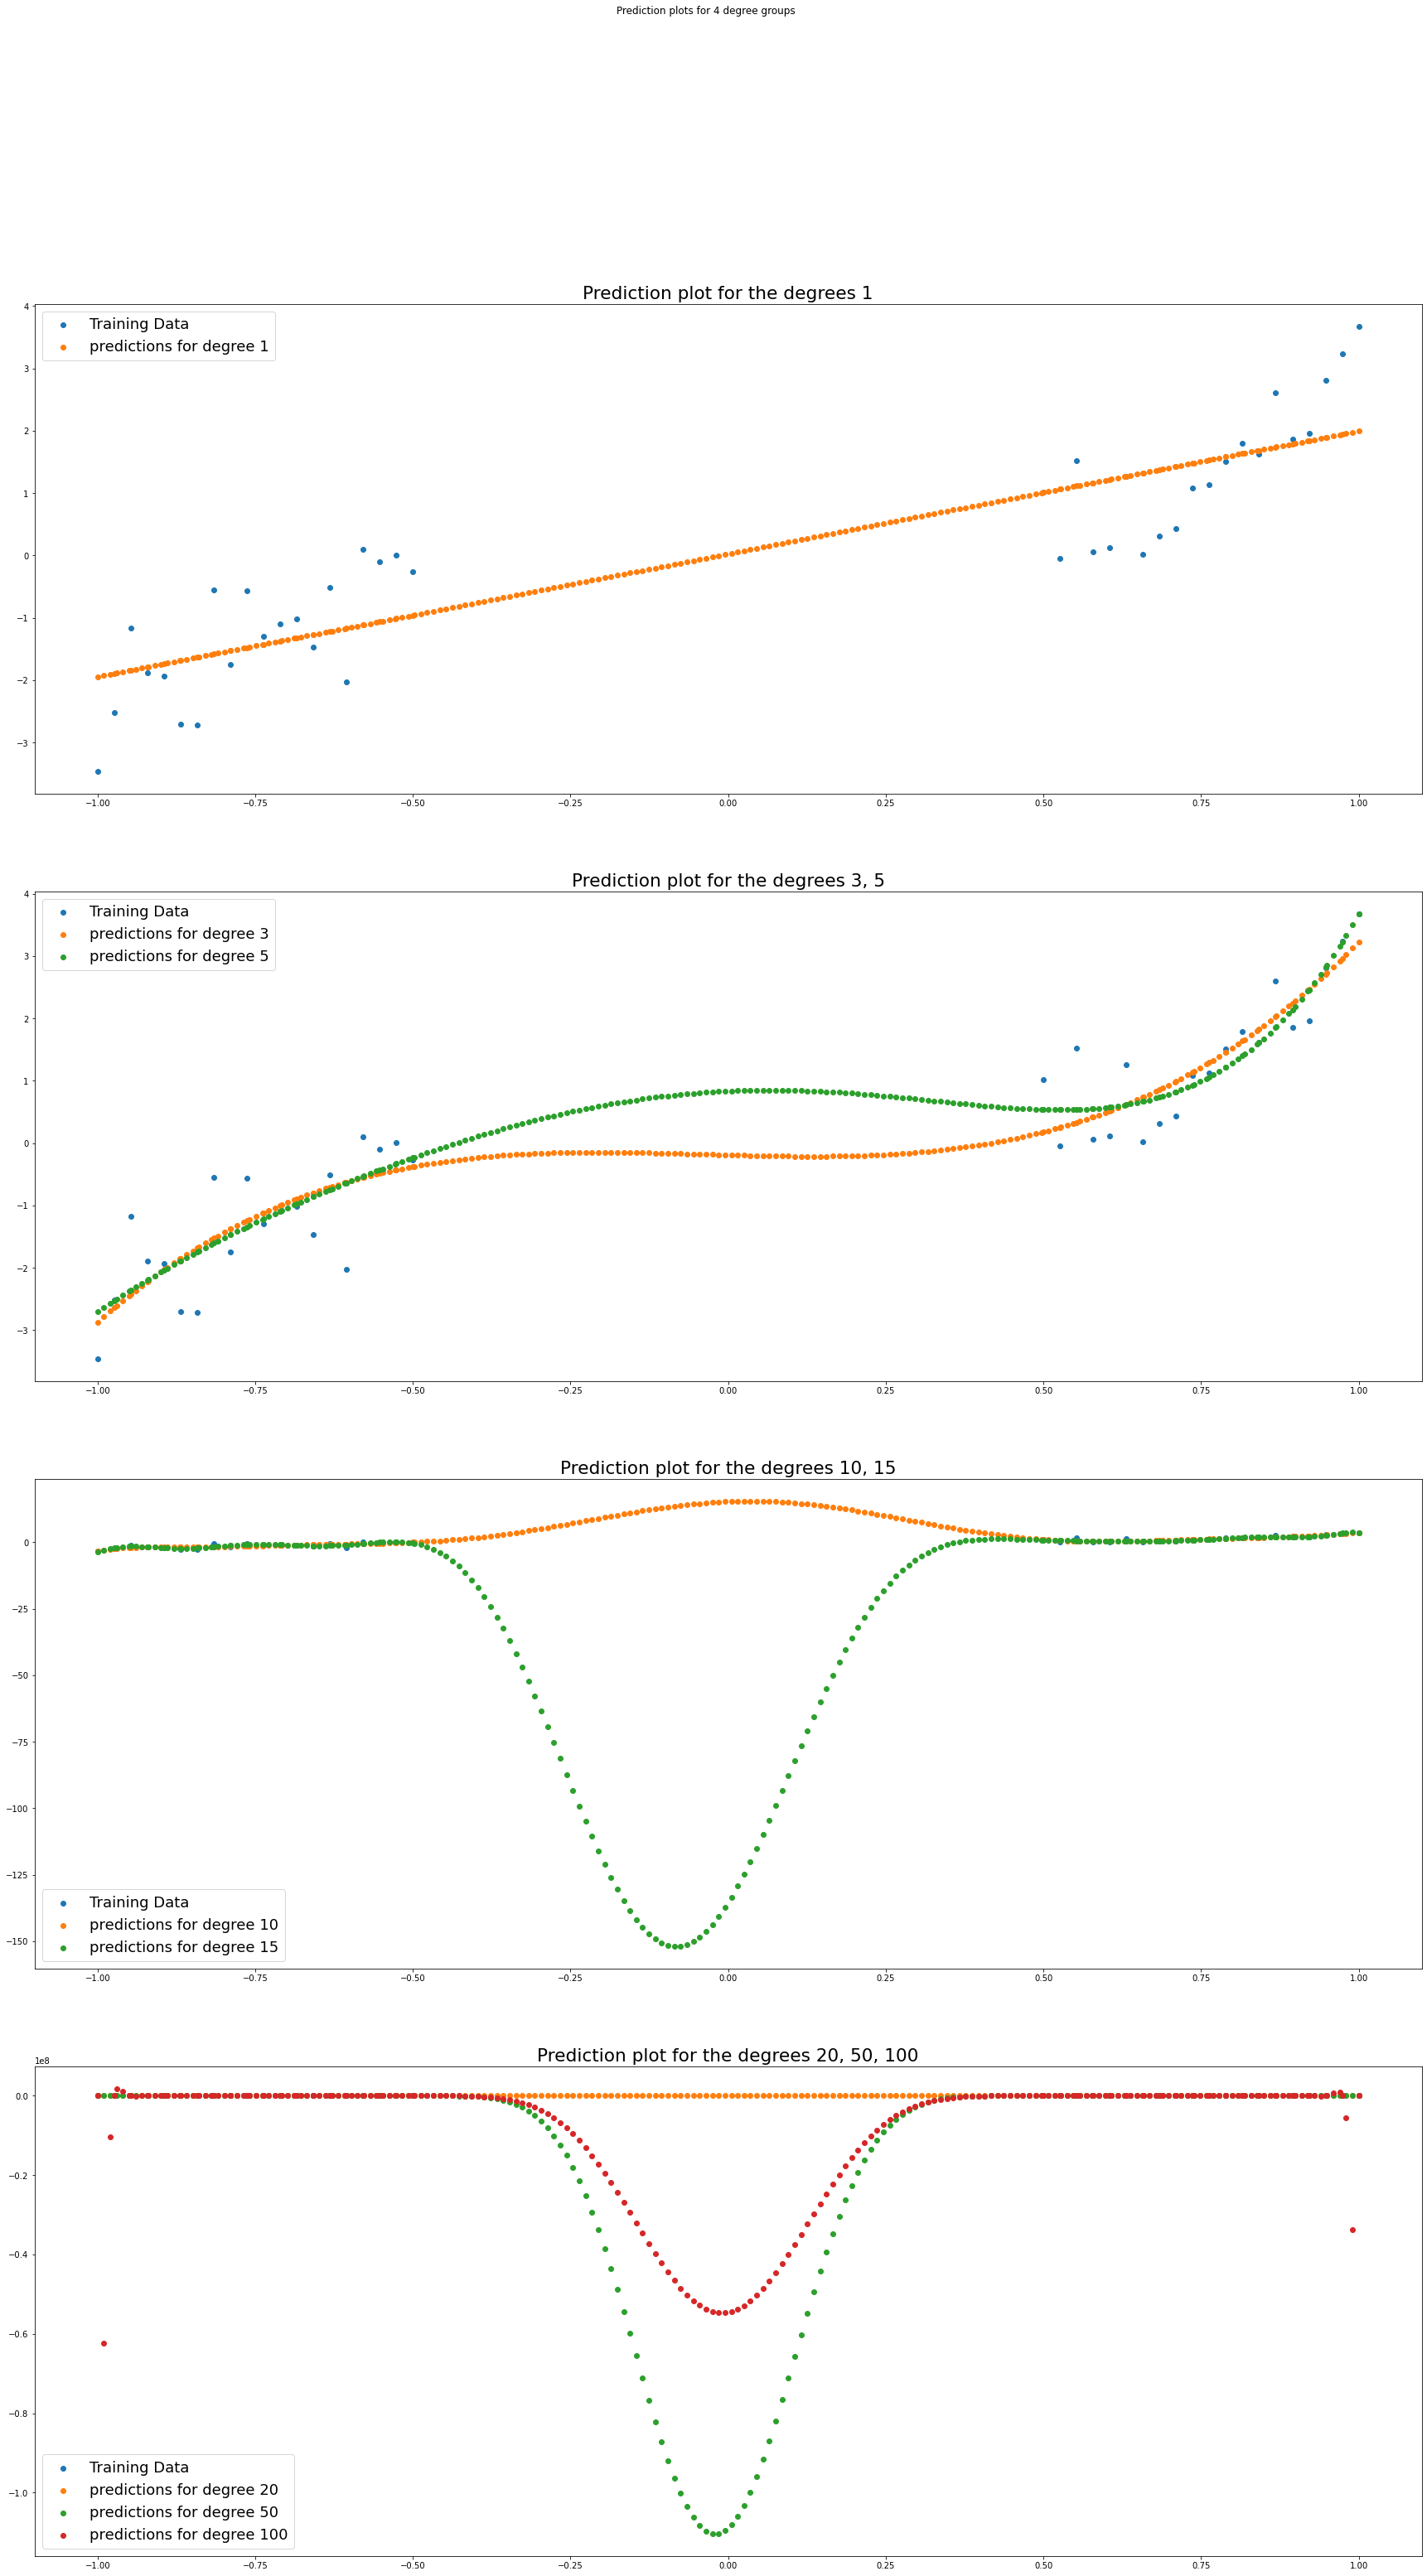

In [4]:
Degrees_considered = [[1], [3,5], [10, 15], [20, 50, 100]]
fig, axes =  plt.subplots(4, 1, figsize=(30, 50))
plt.suptitle('Prediction plots for 4 degree groups')
plt.rcParams['font.size'] = 18
x_train_fit = x_train.reshape(-1, 1)
x_test_fit = x_test.reshape(-1, 1)
for i, degrees_group in enumerate(Degrees_considered):
    axes[i].scatter(x_train, y_train, label = 'Training Data')
    for d in degrees_group:
        polynomial_transformer = PolynomialFeatures(degree=d)
        polynomial_transformer.fit(x_train_fit)
        x_train_d = polynomial_transformer.transform(x_train_fit)
        x_test_d = polynomial_transformer.transform(x_test_fit)
        model = LinearRegression().fit(x_train_d, y_train)
        predictions = model.predict(x_test_d)
        axes[i].set_title('Prediction plot for the degrees '+ str(degrees_group)[1:-1])
        axes[i].scatter(x_test, predictions, label = 'predictions for degree '+str(d))
        axes[i].legend()
    

In the context of the problem, a specific case occurs: $\textbf{we are trying to predict the distribution of unkknown data on the interval [-0.5; 0.5]}$. Therefore, we are looking for a model that would be able to predict the unknown behaviour, this is why we do not with to make wild assumptions on the beahviour of our model on unknown data. 

Several behaviors appear based on the complexity of the model (i.e the degree of the polynomial used):
- Low complexity (degree = 1): the model is very simple, does not overfit the data. However, one could assume that this over-simple model will not efficiently capture patterns in the data since it does not efficiently follows the trend of the training data. 
- Reasondable complexity (degree = 3, 5): the model is complex, but not over-complex in the sense that it apparently does not overfit the data. We could infer that there is some potential to capture the underlying distribution patterns.
- High complexity (degree = 10, 15): the values taken by the model begin to distantiate substantially from the training data, making a wild assumption on the distribution of the testing data between -0.5 and 0.5. 
- Very high complexity (degree = 20, 50, 100): the model is very complex and takes very high values in the middle of the interval where no training point has been seen, therefore assuming hypotheses that we may not have the knowledge to validate. Also, these complex models with high polynomial degrees could have extreme coefficients when interpolating the data, yielding extreme values at $x=+/-1$ (that were not present before hand since the degrees of the polynomial was very high and the monomial adjacent to the coefficient substantially lowered the impact of the coefficient.

2. **(Model Selection)** Later in the course, we will study a number of metrics commonly used for selecting between different MLE models. All of these metric essentially encode Occam's Razor: select the minimal complexity of model that satisfies some pre-determined modeling goal. <br><br>
For now, a very simple method for selecting the optimal degree is via cross-validation (by bootstrap):

  1. randomly sample two datasets, `x_train`, `x_valid`, from the data generating function: one for training and one for validation. Fit an MLE  polynomial model of degree $d$ on the training data and evaluate its performance on the validation data. Over $S$ number of such randomly sampled pairs of datasets, average the model's validation performance.
  2. plot the validation score as a function of model complexity, the polynomial degree $d$. 
  3. based on the plot, select the the minimal degree that achieves a high average validation performance (i.e. look for the 'elbow' of the plot).

  Explain why performing model selection by cross-validation mitigates the risk of choosing an undesirable polynomial (identified in Problem 1)?<br><br>
  Implement model selection by cross-validation for the toy dataset generated in Problem 1 using MSE as your performance metric and select an optimal degree from $D=[1,3,5,10,15,20,50,100]$.

Performing model selection by cross-validation mitigates the risk of overfitting. Indeed, the previous question raised the problem of selecting model when we did not have any ground-truth value. This way of keeping a validation set in order to evaluate our model on $\textbf{unseen data}$ allows to estimate how well our model performs. This also allows to see which models do overfit the training data distribution, or make too wild assumptions about the distribution of unseen data that may result in 'model anomalies' (such as the very high values taken around 0 for high-complexity models).

### Step A : Perform S-fold Cross-Validation, S=10

In [5]:
cross_validation_scores = []
S = 10
Degrees_considered = [1, 3, 5, 10, 15, 20, 50, 100]
for d in Degrees_considered:
    mse_scores = []
    for i in range(S):
        x_train, y_train, _ = generate_data(number_of_points=20)
        x_val, y_val, _ = generate_data(number_of_points=20)
        x_train_fit = x_train.reshape(-1, 1)
        x_val_fit = x_val.reshape(-1, 1)
        polynomial_transformer = PolynomialFeatures(degree=d)
        polynomial_transformer.fit(x_train_fit)
        x_train_d = polynomial_transformer.transform(x_train_fit)
        x_val_d = polynomial_transformer.transform(x_val_fit)
        model = LinearRegression().fit(x_train_d, y_train)
        predictions = model.predict(x_val_d)
        mse_score = np.mean((predictions - y_val)**2)
        mse_scores.append(mse_score)
    cross_validation_scores.append(np.mean(mse_scores))

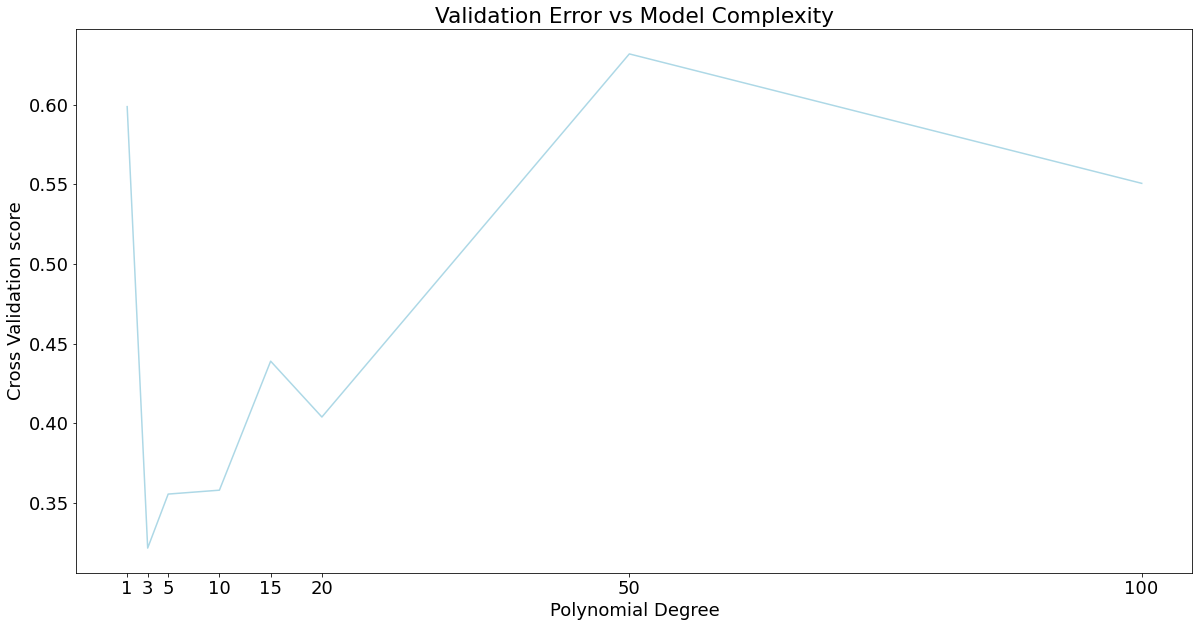

In [6]:
plt.figure(figsize = (20, 10))
plt.xticks(Degrees_considered)
plt.xlabel('Polynomial Degree')
plt.ylabel('Cross Validation score')
plt.title('Validation Error vs Model Complexity')
plt.plot(Degrees_considered, cross_validation_scores, color='lightblue', label = 'Validation MSE')
plt.show()

Therefore, based on model selection by Cross-Validation, I would choose the $\textbf{model with Polynomial degree = 3.}$

3. **(Uncertainty Estimation)** As you have seen in HW0, we often use the bootstrap predictive uncertainty of MLE models as an indicator of our confidence in the model's output. Increasingly, in practice, decisions making are deferred to human experts when the model's predictive uncertainty is too high. <br><br>
Given your understanding of the dataset (`x_train` and `x_test`), describe what the model uncertainty ***should*** ideally look like across the input space (i.e. if you plotted the model uncertainty as a function of $x$, what would it look like)? Justify your answer: consider the context of the problem - the test input has undergone covariate shift and is dissmilar to the training input, what kind of uncertainty would help you mitigate risk under this condition?<br><br>
A common practice for estimating predictive uncertainty is to fit a large number of (bootstrap) models on the training data (this collection of models is called an **ensemble**), then, at an input $x$, use the variance of the ensemble predictions to estimate the uncertainty at $x$. Plot the 95% predictive interval of 200 bootstrap MLE polynomial models for each degree $D=[1,3,5,10,15,20,50,100]$, arrange your plots as  subplots in a single figure. For which polynomial degree do you obtain the predictive uncertainty that is most ideal (according to your description above)? Is this the degree you selected in Problem 2? Explain why you would or would not expect the optimal degree in Problem 2 to yield the most ideal uncertainty estimate.<br><br>
Make the same plots the 95% predictive intervals for degrees $D=[1,3,5,10,15,20,50,100]$, with models fitted on larger training datasets - set `number_of_points` to 50, 100, 500, 1000 (arrange all these plots in a single figure). What is happening to the predictions of the ensemble in the training data rich region? What is happening to the predictions of the ensemble in the training data poor region? Are these expected behaviours (relate what you see in both cases to the asymptotic properties of MLE)?
<br><br>
When the training data is abundant (`number_of_points=1000`), are any of the 95% predictive intervals ideal (according to your description above)? What does this imply about the feasibility of using the variance of the ensemble predictions to estimate predictive uncertainty at an input $x$?

### Intuition for Model uncertainty

After performing boostrap predictive uncertainty of MLE models, I would like to have a low uncertainty for the x values in [-1; -0.5] and [0.5; 1]. Indeed, those are regions where our model has seen some examples for training data and where we assume that the testing distribution is simular to our training distribution. However, for the x values in [-0.5, 0.5], in order to mitigate the risk of being off for the testing distribution in this region, I would like to have a high uncertainty, in order to take into accounts several scenarios for the testing distribution in this range of x values. 

### Bootstrap, n=200 models

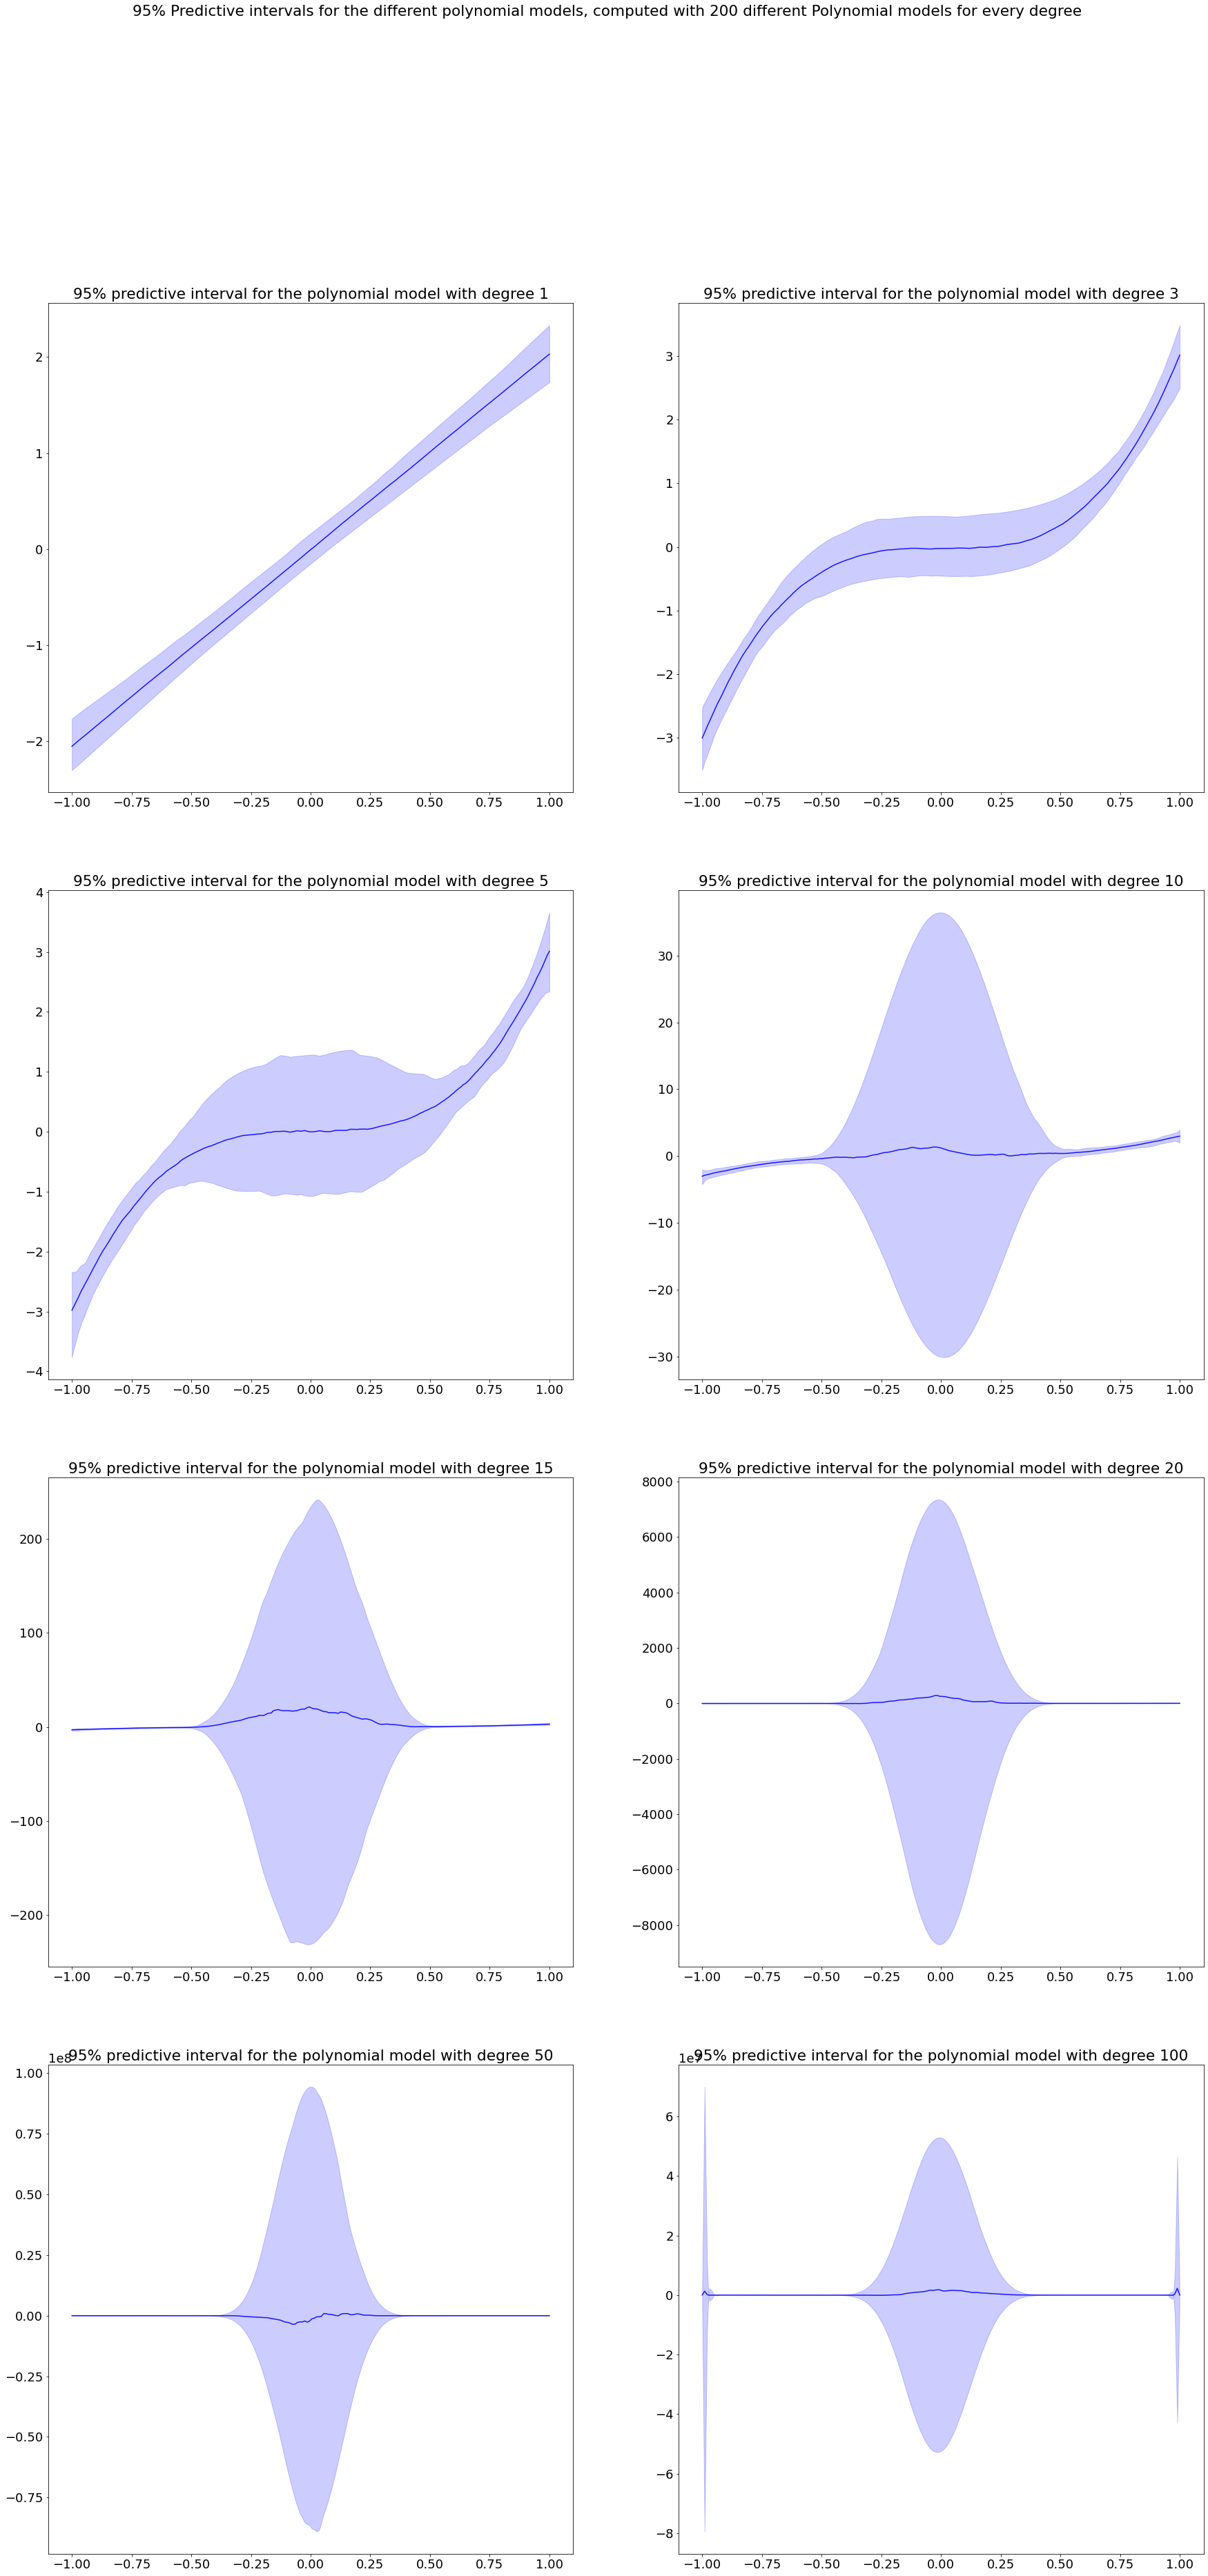

In [7]:
n = 200
Degrees_considered = [1, 3, 5, 10, 15, 20, 50, 100]
fig, axes =  plt.subplots(4, 2, figsize=(30, 60))
fig.suptitle('95% Predictive intervals for the different polynomial models, computed with 200 different Polynomial models for every degree')
for i, d in enumerate(Degrees_considered):
    model_prediction_d = []
    polynomial_transformer = PolynomialFeatures(degree=d)
    for j in range(n):
        x_train, y_train, x_test = generate_data(number_of_points=20)
        x_train_fit = x_train.reshape(-1, 1)
        x_test_fit = x_test.reshape(-1, 1)
        polynomial_transformer.fit(x_train_fit)
        x_train_d = polynomial_transformer.transform(x_train_fit)
        x_test_d = polynomial_transformer.transform(x_test_fit)
        model = LinearRegression().fit(x_train_d, y_train)
        predictions = model.predict(x_test_d)
        model_prediction_d.append(predictions)
    model_prediction_d = np.asarray(model_prediction_d)
    y_pred_ub_d = np.percentile(model_prediction_d, 97.5, axis=0)
    y_pred_median_d = np.percentile(model_prediction_d, 50.0, axis=0)
    y_pred_lb_d = np.percentile(model_prediction_d, 2.5, axis=0)
    axes[i//2, i%2].fill_between(x_test, y_pred_ub_d, y_pred_lb_d, color='blue', alpha=0.2)
    axes[i//2, i%2].plot(x_test, y_pred_median_d, color='blue', alpha=0.9)
    axes[i//2, i%2].set_title('95% predictive interval for the polynomial model with degree '+ str(d))

According to my above description of what an ideal predictive uncertainty would be, I would say that the polynomials of degree 5 or 10 are the one I would be most confident with. This is not the degree selected based on Model Selection via Cross-Validation MSE performance. 

I was not expecting the model with polynomial degree = 3 to always have the ideal predictive uncertainty. Indeed, the ideal expected predictive uncertainty is not that confident with assigning values between [-0.5; 0.5]. This yields in a predictive uncertainty slightly larger in the other ranges of value. Therefore, the distribution of values assigned on the intervals [-1; -0.5] and [0.5; 1] would be quite broad, resulting in not having the best MSE based on cross-validation predictions on these two intervals. Therefore, a higher MSE can be a sign that the predictive uncertainty is larger and therefore having the expected distribution. 

### Predictive Uncertainty when varying the number of data points

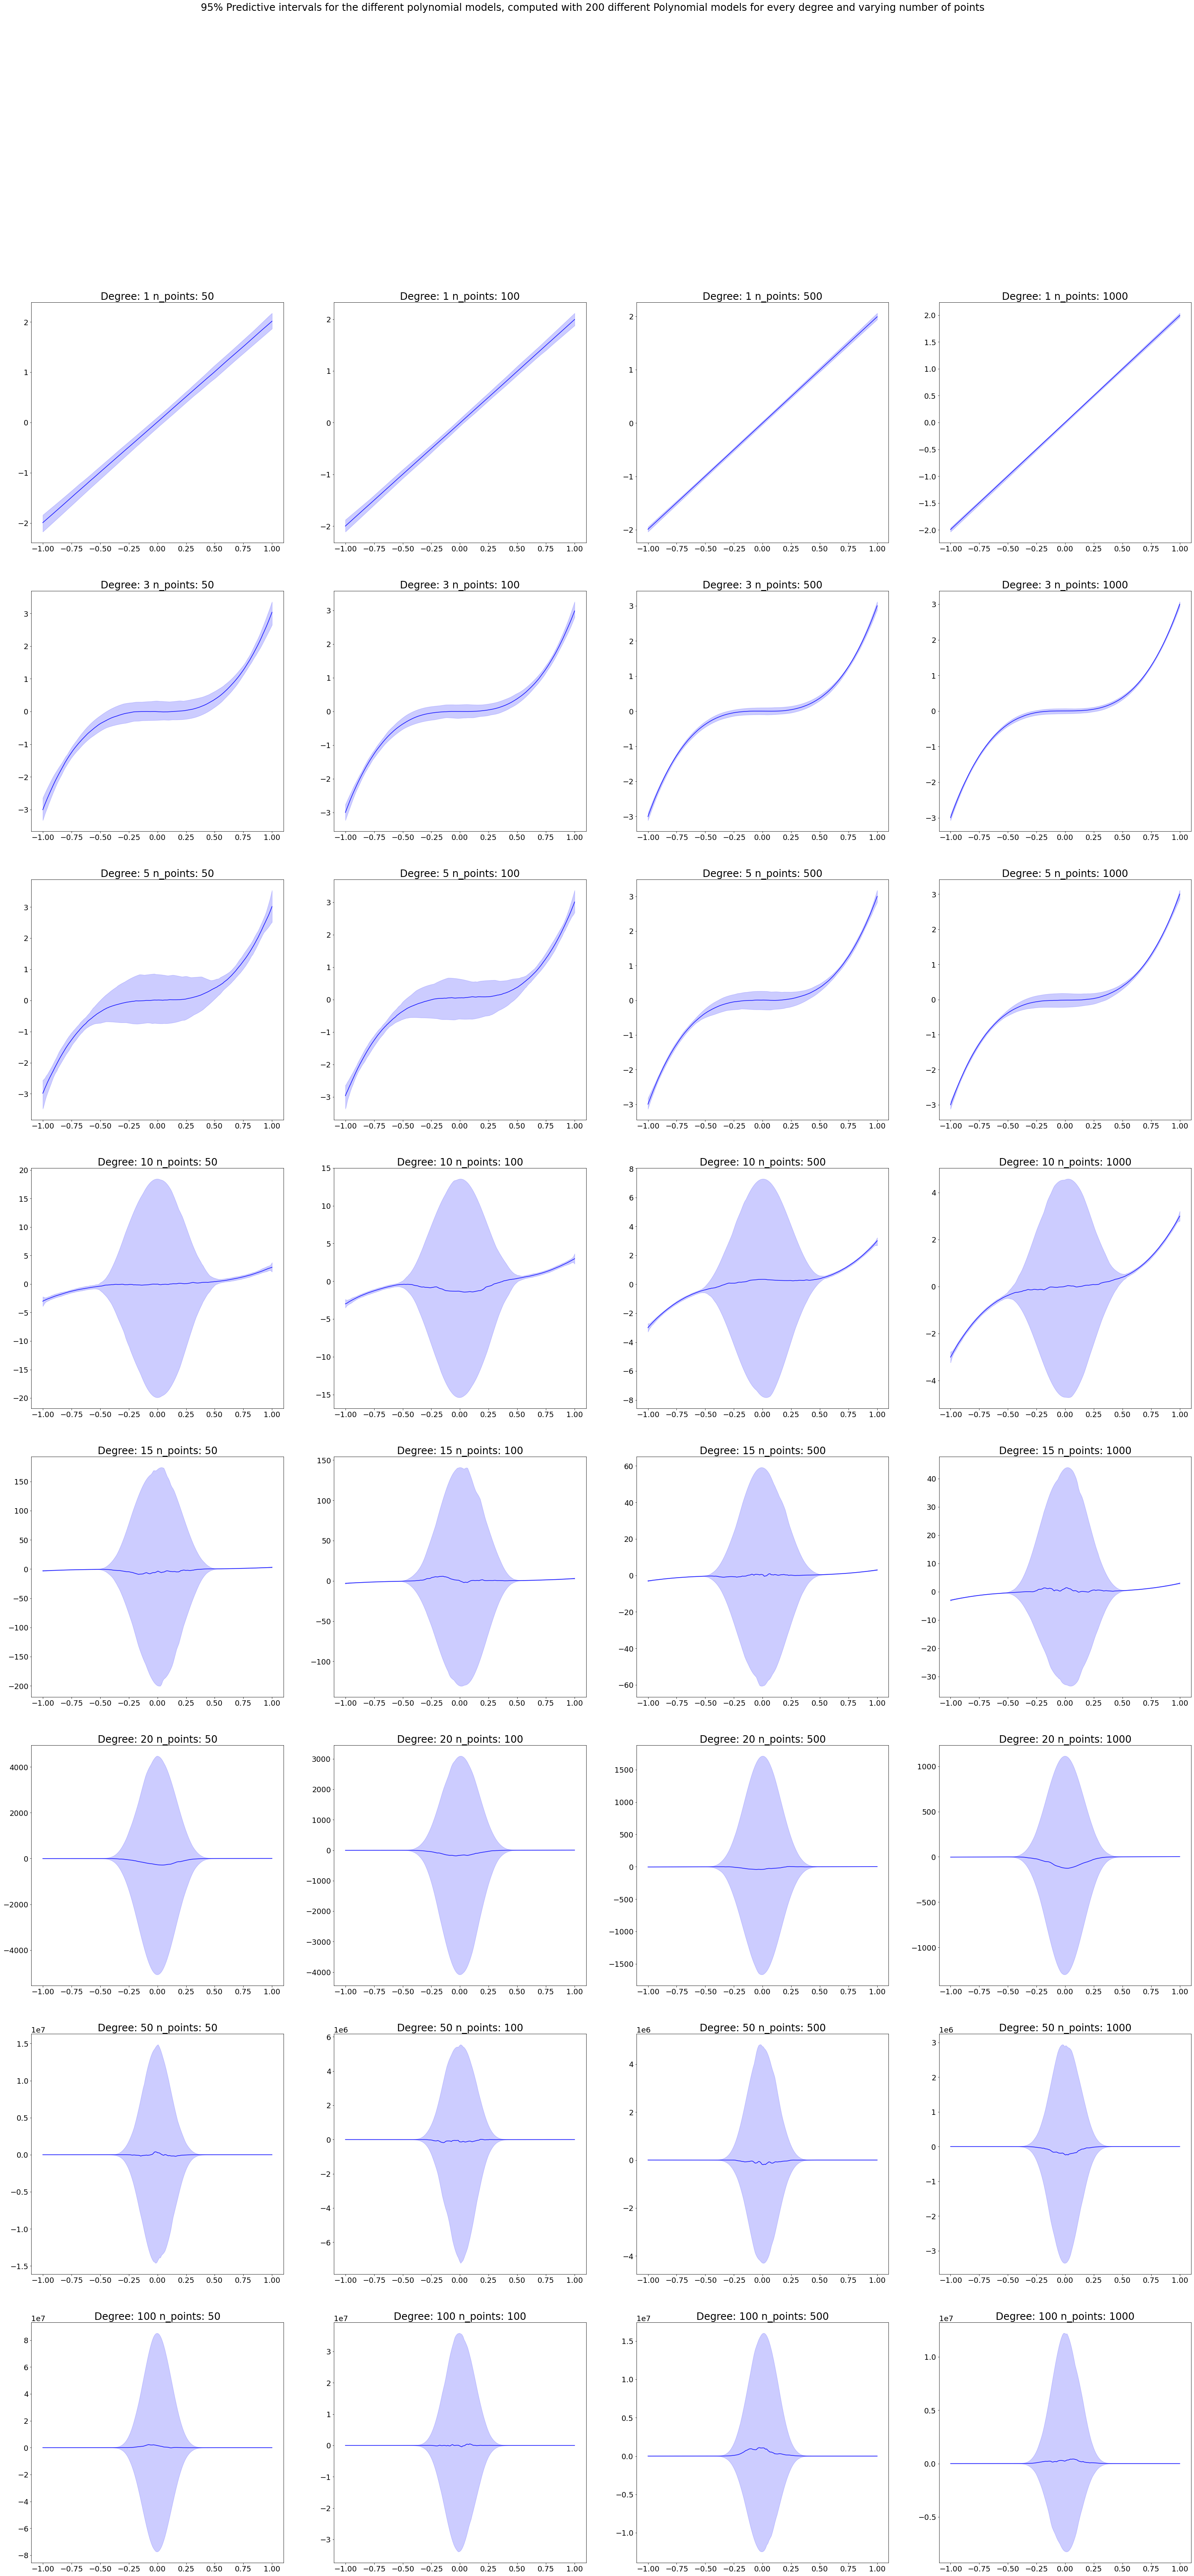

In [8]:
bootstraps = 200
Degrees_considered = [1, 3, 5, 10, 15, 20, 50, 100]
number_of_points = [50, 100, 500, 1000]
fig, axes =  plt.subplots(8, 4, figsize=(50, 100))
plt.rcParams['font.size'] = 20
for i, d in enumerate(Degrees_considered):
    for k, n in enumerate(number_of_points):
        model_prediction_d = []
        polynomial_transformer = PolynomialFeatures(degree=d)
        for j in range(bootstraps):
            x_train, y_train, x_test = generate_data(number_of_points=n)
            x_train_fit = x_train.reshape(-1, 1)
            x_test_fit = x_test.reshape(-1, 1)
            polynomial_transformer.fit(x_train_fit)
            x_train_d = polynomial_transformer.transform(x_train_fit)
            x_test_d = polynomial_transformer.transform(x_test_fit)
            model = LinearRegression().fit(x_train_d, y_train)
            predictions = model.predict(x_test_d)
            model_prediction_d.append(predictions)
        model_prediction_d = np.asarray(model_prediction_d)
        y_pred_ub_d = np.percentile(model_prediction_d, 97.5, axis=0)
        y_pred_median_d = np.percentile(model_prediction_d, 50.0, axis=0)
        y_pred_lb_d = np.percentile(model_prediction_d, 2.5, axis=0)
        axes[i, k].fill_between(x_test, y_pred_ub_d, y_pred_lb_d, color='blue', alpha=0.2)
        axes[i, k].plot(x_test, y_pred_median_d, color='blue', alpha=0.9)
        axes[i, k].set_title('Degree: '+str(d)+' n_points: '+str(n))
fig.suptitle('95% Predictive intervals for the different polynomial models, computed with 200 different Polynomial models for every degree and varying number of points')
fig.subplots_adjust(top=0.88)

In the data rich region, adding more data points leads to a $\textbf{lower predictive uncertainty for the model.}$ 
In the data poor region, adding more data yields to $\textbf{slight changes in the predictive uncertainty}$.

Let us recall the effect of adding more data on MLE: we know that, under certain hypotheses the MLE is asymptotically unbiased and consistent. One of these $\textbf{crucial hypotheses}$ is that $\textbf{the model is well-specified}$, meaning that the observed is drawn from the same model class as the model being fitted. Therefore, two cases appear: 
- On the data rich region, adding more data points leads to Estimator consistency, explaining why the predictive uncertainty computed by bootstraping of MLE diminishes: this is due to the fact that on these regions, the model is well-specified.
- On the data poor region, the model $\textbf{is not well specified}$, yielding to the fact that adding data points does not lead to more consistency for the estimator. Therefore, several behavious occur: for low complexity models, adding training points in data rich regions add some constraints on the shape of the fitted model, explaining why the predictive uncertainty may be lower on data poor region. However, for high complexity models, adding such number of training points does not allow to impose a shape on the model since it has too many degrees of freedom, explaining why the predictive uncertainty is not changing for these complex models on data poor regions. 

When the data is abundant, the models with degree polynomials 10 or 15 have good predictive intervals shape in zones with poor data, but not for regions where the data is rich. Since any of the model presents the desired form for the predictive ijnterval, this implies that using this bootstraping method for point-wise predictive uncertainty could be a wrong way of estimating model uncertainty.

4. **(Effect of Regularization)** In practice, MLE models are nearly always trained with regularization (since they tend to overfit to the training data). Here, we will explore the effect of adding $\ell_2$ regularization to our MLE polynomial models (that is, use the `Ridge` regression model from `sklearn` after augmenting your input with polynomial features). <br><br>
For a toy dataset with 40 observations (`number_of_points=20`), plot the 95% predictive intervals for degrees $D = [1,3,5,10,15,20,50,100]$ and regularization strengths `alpha = [5e-3, 1e-2, 1e-1, 1e0, 1e1]` (you should organize these plots in a grid).<br><br>
Describe the effect of regularization on the bootstrap uncertainties. Looking at these results, are the goals of $\ell_2$ regularization and obtaining useful predictive uncertatinty estimation necessarily well-aligned?


In [9]:
from sklearn.linear_model import Ridge

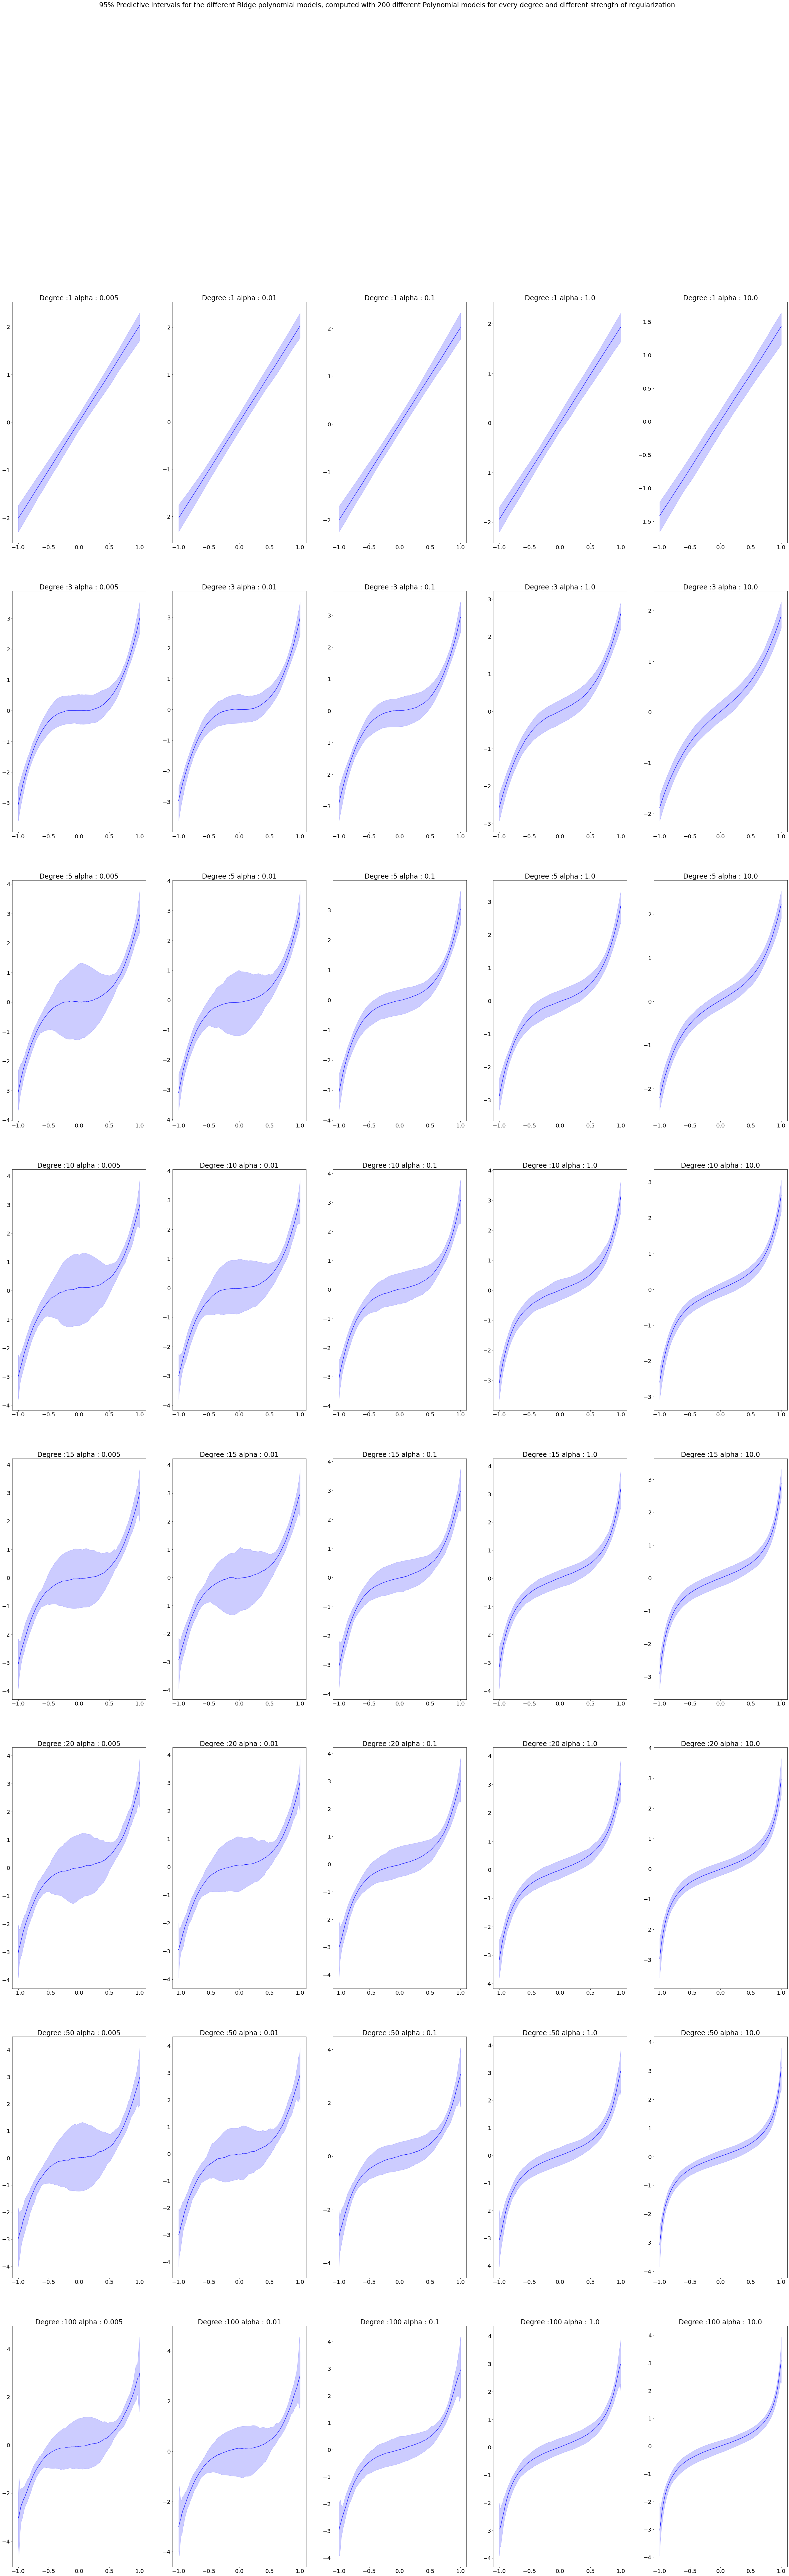

In [10]:
bootstraps = 200
Degrees_considered = [1, 3, 5, 10, 15, 20, 50, 100]
alphas = [5e-3, 1e-2, 1e-1, 1e0, 1e1]
fig, axes =  plt.subplots(8, 5, figsize=(50, 150))
plt.rcParams['font.size'] = 20
for i, d in enumerate(Degrees_considered):
    for k, alpha in enumerate(alphas):
        model_prediction_d = []
        polynomial_transformer = PolynomialFeatures(degree=d)
        for j in range(bootstraps):
            x_train, y_train, x_test = generate_data(number_of_points=20)
            x_train_fit = x_train.reshape(-1, 1)
            x_test_fit = x_test.reshape(-1, 1)
            polynomial_transformer.fit(x_train_fit)
            x_train_d = polynomial_transformer.transform(x_train_fit)
            x_test_d = polynomial_transformer.transform(x_test_fit)
            model = Ridge(alpha=alpha).fit(x_train_d, y_train)
            predictions = model.predict(x_test_d)
            model_prediction_d.append(predictions)
        model_prediction_d = np.asarray(model_prediction_d)
        y_pred_ub_d = np.percentile(model_prediction_d, 97.5, axis=0)
        y_pred_median_d = np.percentile(model_prediction_d, 50.0, axis=0)
        y_pred_lb_d = np.percentile(model_prediction_d, 2.5, axis=0)
        axes[i, k].fill_between(x_test, y_pred_ub_d, y_pred_lb_d, color='blue', alpha=0.2)
        axes[i, k].plot(x_test, y_pred_median_d, color='blue', alpha=0.9)
        axes[i, k].set_title('Degree :'+str(d) + ' alpha : '+str(alpha))
fig.suptitle('95% Predictive intervals for the different Ridge polynomial models, computed with 200 different Polynomial models for every degree and different strength of regularization')
plt.show()

From the previous plot, we can infer that $\textbf{regularization diminishes boostrstrap uncertainties}$.
However, one major drawback of regularization in this case is that it dimiinishes bootstrap uncertainties in the $\textbf{entire range of values}$ for x, which is something we do not want in this situation: we want the model uncertainty to remain high in the regions with poor data. Therefore, the goals of ℓ2  regularization and obtaining useful predictive uncertatinty estimation are not necessarily well-aligned: constraining the values of parameters yield to over-confident models (due to the fact that it limits model's flexibility ) not capturing the uncertainty in data. 

## Part II: Bayesian Polynomial Regression
In this problem, your task is to perform Bayesian polynomial regression on the toy datasets in Part I. That is, assume that the outcome $y$ can be modeled by the following process:

\begin{align}
y &= f(x) + \epsilon = w_0 + w_1x + w_2x^2 + \ldots + w_Dx^D + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)\\
w_d &\sim \mathcal{N}(0, \alpha)
\end{align}

where $\alpha$ is a hyperparameter and must be fixed before modeling and inference begins.

1. **(Bayesian Kernel Regression)** Just as we can treat a polynomial regression model like a multi-linear regression model after ***transforming*** the input data by adding polynomial features. We can treat Bayesian polynomial regression like Bayesian linear regression on top of the transformed inputs. Formally, the map that takes an input $\mathbf{x}_n \in \mathbb{R}^{D'}$ and transforms it into a new input $\phi(\mathbf{x}_n) \in \mathbb{R}^{D}$ is called a **feature map**, $\phi: \mathbb{R}^{D'} \to \mathbb{R}^{D}$, for 1-dimensional input $x \in \mathbb{R}$, the polynomial feature map of degree $D$ is defined by
\begin{align}
\\\phi: \mathbb{R} &\to \mathbb{R}^D\\
x &\mapsto [1, x, x^2, \ldots, x^D]\\
\end{align}
<br> Thus, we can write rewrite Bayesian polynomial regression as
\begin{align}
\\y &= \mathbf{w}^\top \mathbf{x} + \epsilon, \quad \epsilon \sim \mathcal{N}(0, 0.3)\\
\mathbf{w} &\sim \mathcal{N}(0, \alpha I_{D\times D})\\
\end{align}
<br>Denote the $N\times D$ matrix of transformed inputs by $\Phi$, where the $n$-th row of the matrix is the $n$-th input $\mathbf{x}_n$ transformed by the feature map, $\phi(\mathbf{x}_n)$. Using this notation, write out the closed form for the posterior for Bayesian polynomial regression in terms of $\Phi$ (you don't need to rederive anything, just make the appropriate substitutions in the formula you derived in HW0).
<br><br>
For $\alpha = 1$ and $D=5$, visualize the 95% posterior predcitve interval of a Bayesian polynomial regression for a toy dataset with 40 observations (set `number_of_points=20`).
<br><br>
When the feature map $\phi$ is a general (usually non-linear transformation), applying Bayesian linear regression on the transformed input is called **Bayesian Kernel Regression**. Choose your own non-linear feature map $\phi: \mathbb{R} \to \mathbb{R}^5$ and visualize the 95% posterior predictive interval of the Bayesian kernel regression for your choice of $\phi$. Compare the visualization to the that for Bayesian polynomial regression. Does the posterior predictive of your Bayesian kernel regression capture important properties of the posterior predictive of the Bayesian polynomial regression model?
<br><br>
**Note:** we highly recommend that you implement the following feature map:
<br><br>
\begin{align}
\phi: \mathbb{R}^{D'} &\to \mathbb{R}^D\\
\mathbf{x} &\mapsto \left[\sqrt{\frac{2}{D}} \cos(w_1^\top x + b_1), \ldots, \sqrt{\frac{2}{D}} \cos(w_D^\top x + b_D)\right]
\end{align}
<br>where $b_d \sim [0, 2\pi]$ and $w_d \sim \mathcal{N}(0, \beta I_{D'\times D'})$ need to be randomly sampled and fixed before modeling and inference. For this exercise, we suggest setting $\beta=10$. The features generated by $\phi$ are called **Random Fourier Features**. As the number of features $D$ tends to infinity, the resulting Bayesian kernel regression model tends to an important type of Bayesian (nonparametric) model called Gaussian Process model. We will revisit the connection between Bayesian kernel regression and Gaussian processes in the latter part of the course.

### Closed form of the Bayesian Polynomial Regression
According to the formulas we derived in HWO, we can directly say that the posterior for the Bayesian polynomial regression has a Gaussian Distribution $p(w | \mathbf{y}, \mathbf{X}) \sim \mathcal{N}(\mu, \Sigma)$ with parameters 
$$
\mu = \left(\frac{1}{\alpha}I_{DxD} + \frac{1}{\sigma^2}\mathbf{\phi(X)}^\top\mathbf{\phi(X)}\right)^{-1} \left(\frac{1}{\sigma^2}\mathbf{\phi(X)}^\top\mathbf{y} \right).
$$
$$
\Sigma = \left(\frac{1}{\alpha}I_{DxD} + \frac{1}{\sigma^2}\mathbf{\phi(X)}^\top\mathbf{\phi(X)}\right)^{-1}
$$

### VIsualization of the 95% posterior predictive interval for $p(w | \mathbf{y}, \mathbf{X})$

In [11]:
polynomial_transformer = PolynomialFeatures(degree=5)
x_train, y_train, x_test = generate_data(number_of_points=20)
x_train_fit = x_train.reshape(-1, 1)
x_test_fit = x_test.reshape(-1, 1)
polynomial_transformer.fit(x_train_fit)
x_train_d = polynomial_transformer.transform(x_train_fit)
x_test_d = polynomial_transformer.transform(x_test_fit)
posterior_predictions, posterior_predictive_samples = get_posterior_samples(1, 0.3, x_train_d, y_train, x_test_d, samples = 1000)
y_pred_ub_pp = np.percentile(posterior_predictive_samples, 97.5, axis=0)
y_pred_median_pp = np.percentile(posterior_predictive_samples, 50.0, axis=0)
y_pred_lb_pp = np.percentile(posterior_predictive_samples, 2.5, axis=0)

Text(0.5, 1.0, '95% posterior predictive interval for the polynomial model with degree 5')

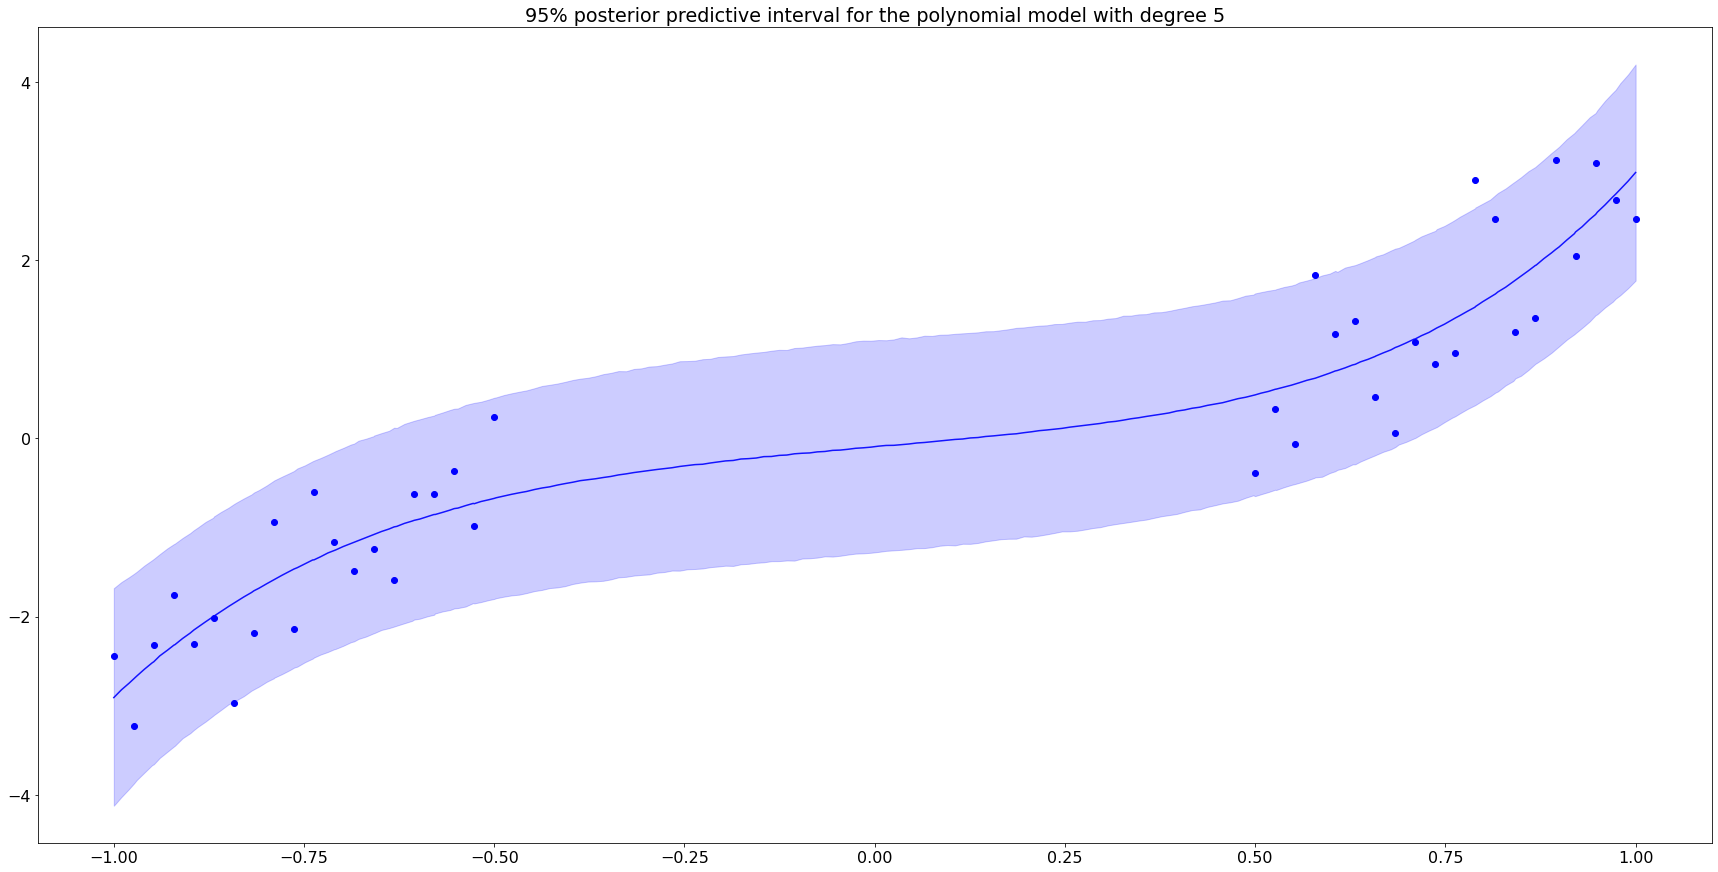

In [12]:
plt.figure(figsize=(30, 15))
plt.rcParams['font.size'] = 16
plt.fill_between(x_test, y_pred_ub_pp, y_pred_lb_pp, color='blue', alpha=0.2)
plt.plot(x_test, y_pred_median_pp, color='blue', alpha=0.9)
plt.scatter(x_train, y_train, color='blue')
plt.title('95% posterior predictive interval for the polynomial model with degree 5')

### Bayesian Kernel Regression with Fourier Transform

In [13]:
𝐷 = [1,3,5,10,15,20,50,100]
b = {d: np.random.rand(d)*2*np.pi for d in D}
variance = 10
mean = 0
coefficients_fourier_w = {d: np.random.normal(mean, variance, size=d) for d in D}

In [14]:
def transformation_fourier(x, d):
    return np.sqrt(2/5)*np.cos(coefficients_fourier_w.get(d)*x+b.get(d))

In [15]:
x_train, y_train, x_test = generate_data(number_of_points=20)
x_train_fit = x_train.reshape(-1, 1)
x_test_fit = x_test.reshape(-1, 1)
x_train_d = np.asarray([transformation_fourier(x, 5) for x in x_train_fit])
x_test_d = np.asarray([transformation_fourier(x, 5) for x in x_test_fit])
posterior_predictions, posterior_predictive_samples = get_posterior_samples(1, 0.3, x_train_d, y_train, x_test_d, samples = 1000)
y_pred_ub_pp_ft = np.percentile(posterior_predictive_samples, 97.5, axis=0)
y_pred_median_pp_ft = np.percentile(posterior_predictive_samples, 50.0, axis=0)
y_pred_lb_pp_ft = np.percentile(posterior_predictive_samples, 2.5, axis=0)

Text(0.5, 1.0, '95% posterior predictive interval for the polynomial model with degree 5')

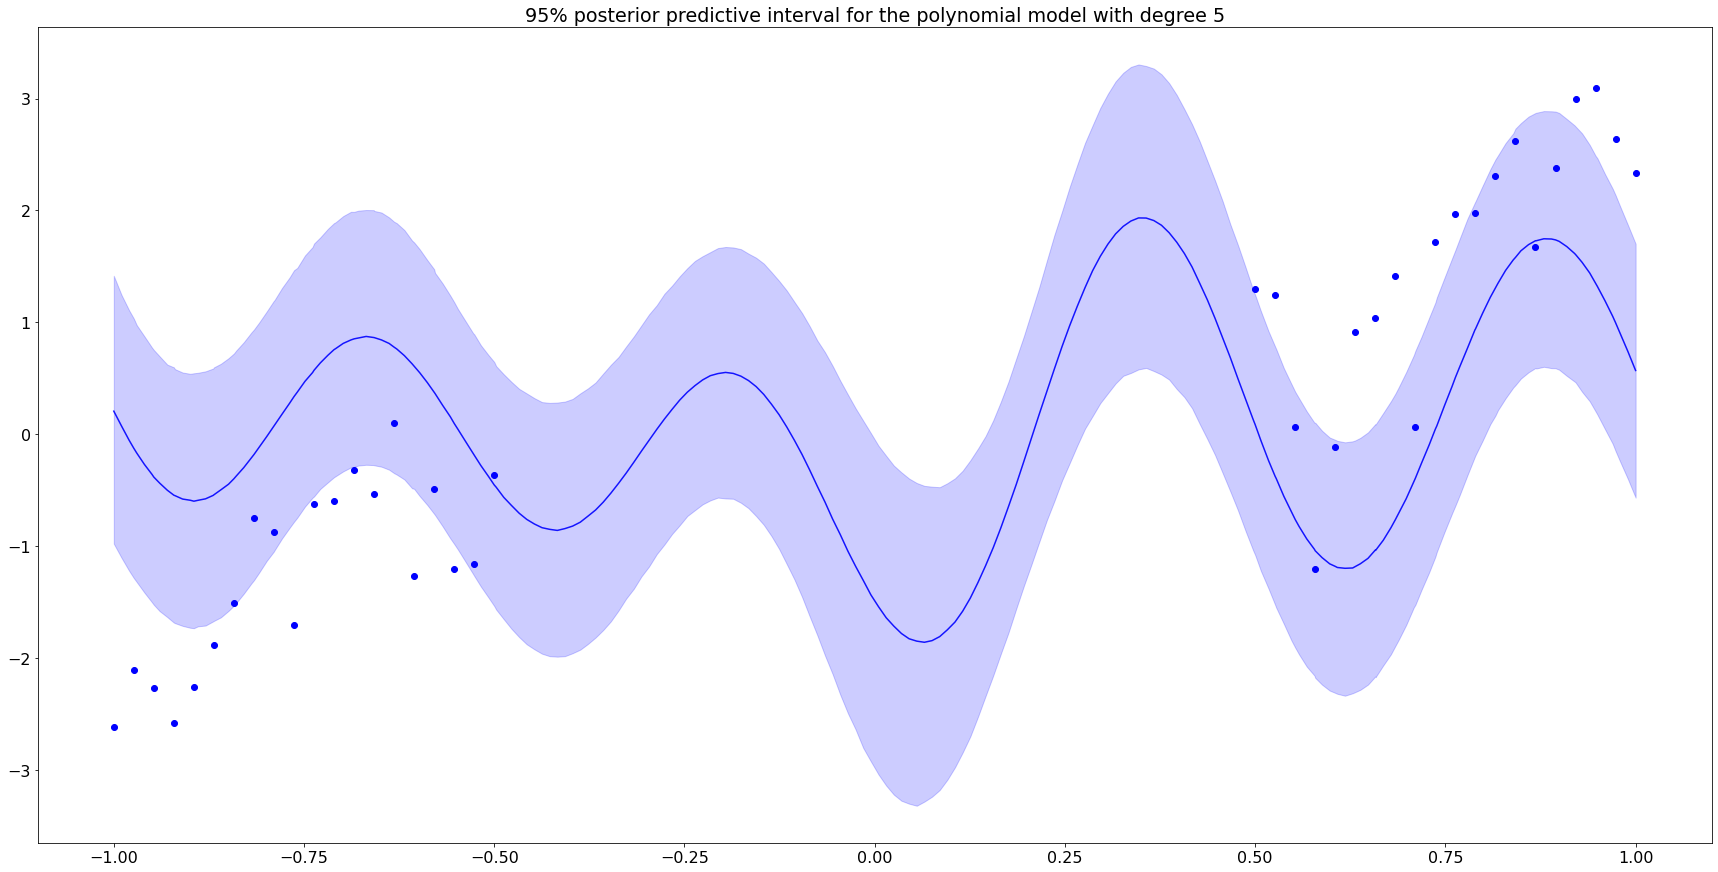

In [16]:
plt.figure(figsize=(30, 15))
plt.rcParams['font.size'] = 16
plt.fill_between(x_test, y_pred_ub_pp_ft, y_pred_lb_pp_ft, color='blue', alpha=0.2)
plt.plot(x_test, y_pred_median_pp_ft, color='blue', alpha=0.9)
plt.scatter(x_train, y_train, color='blue')
plt.title('95% posterior predictive interval for the polynomial model with degree 5')

### Comparison of Feature Maps

From the above plots, we can see that Bayesian Polynomial Regression does not capture the posterior predictive uncertainty in regions with poor training data. This behavior is captured by Bayesian Kernel Regression with Fourier Features. 

2. **(Effect of Model Complexity)** For Bayesian kernel regression, you need to pre-determine the number of features (i.e. $D$) and the hyperparameter $\alpha$ in the prior. For a toy dataset with 40 observations (set number_of_points=20), visualize the 95% posterior predictive interval for $D = [1,3,5,10,15,20,50,100]$ and $\alpha = [0.1, 1, 5, 10, 100]$ (arrange these visualizations in a grid), using either Bayesian polynomial regression or Bayesian kernel regression using Random Fourier Features. 
<br><br>
Based on your visualizaion, describe in intuitive terms what is the role of $\alpha$ and $D$ in determining the shape of the posterior predictive uncertainty. 
<br><br>
***Hint:*** Read Problem 3 before implementing Problem 2, you can implement both at the same time.

In [17]:
import scipy

In [18]:
def get_marginal_likelihood(prior_var, x_matrix, y_train, noise_var = 0.3):
    prior_variance = np.diag(prior_var * np.ones(x_train_d.shape[1]))
    prior_precision = np.linalg.inv(prior_variance)
    joint_precision = prior_precision + x_matrix.T.dot(x_matrix) / noise_var
    joint_variance = np.linalg.inv(joint_precision)
    joint_mean = joint_variance.dot(x_matrix.T.dot(y_train)) / noise_var
    log_likelihood = 0
    for i in range(len(x_train_d)):
        mean = np.dot(joint_mean.T, x_train_d[i])
        sigma = noise_var + np.dot(np.dot(x_train_d[i].T, joint_variance), x_train_d[i])
        simu = (scipy.stats.norm.logpdf(y_train[i], mean, sigma))
        log_likelihood += simu
    return log_likelihood

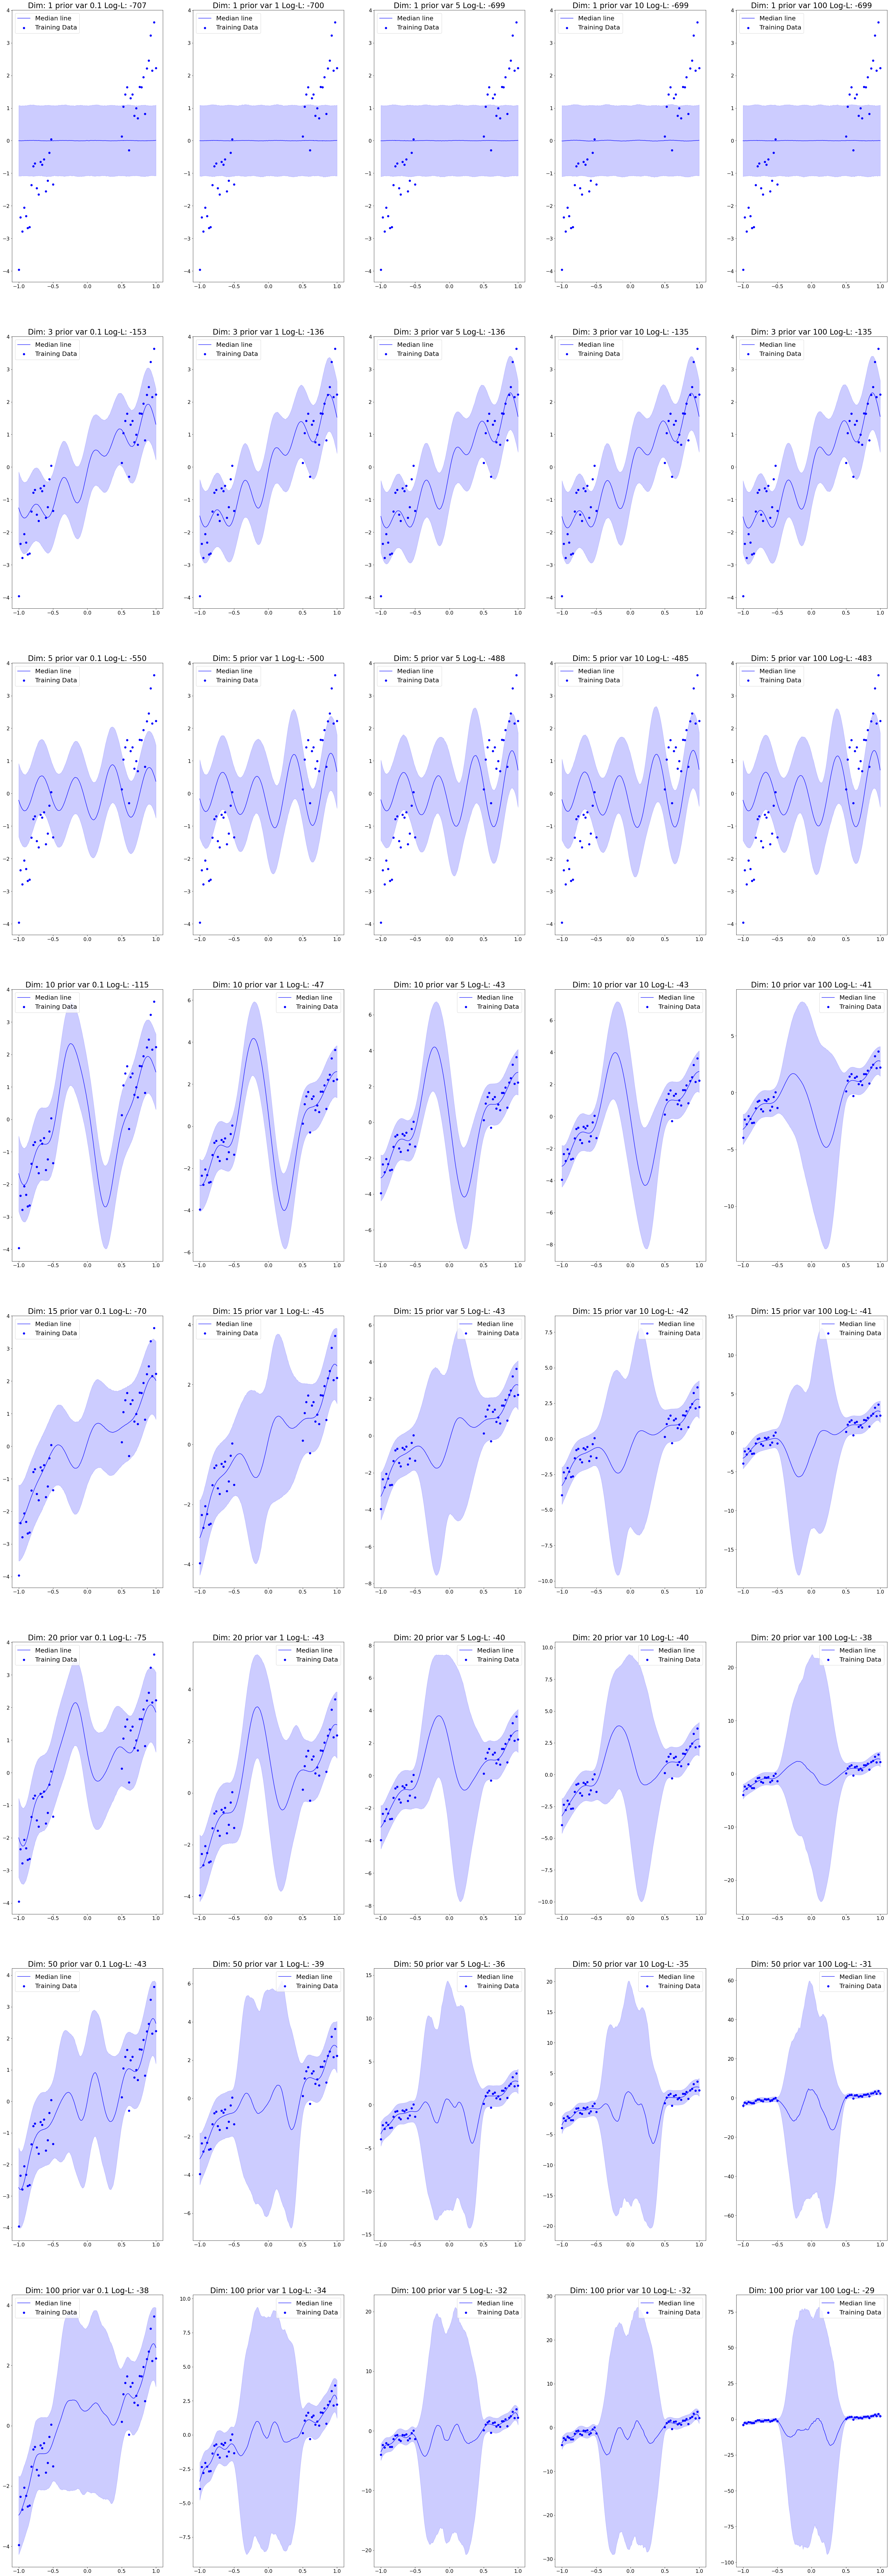

In [19]:
𝐷 = [1,3,5,10,15,20,50,100]
alphas = [0.1, 1, 5, 10, 100]
fig, axes =  plt.subplots(8, 5, figsize=(50, 150))
plt.rcParams['font.size'] = 20
x_train, y_train, x_test = generate_data(number_of_points=20)
x_train_fit = x_train.reshape(-1, 1)
x_test_fit = x_test.reshape(-1, 1)
for i, d in enumerate(D):
    for k, alpha in enumerate(alphas):
        x_train_d = np.asarray([transformation_fourier(x, d) for x in x_train_fit])
        x_test_d = np.asarray([transformation_fourier(x, d) for x in x_test_fit])
        training_log_likelihood_score = get_marginal_likelihood(alpha, x_train_d,  y_train)
        posterior_predictions, posterior_predictive_samples = get_posterior_samples(alpha, 0.3, x_train_d, y_train, x_test_d, samples = 1000)
        y_pred_ub_pp_ft = np.percentile(posterior_predictive_samples, 97.5, axis=0)
        y_pred_median_pp_ft = np.percentile(posterior_predictive_samples, 50.0, axis=0)
        y_pred_lb_pp_ft = np.percentile(posterior_predictive_samples, 2.5, axis=0)
        model_prediction_d = np.asarray(model_prediction_d)
        axes[i, k].fill_between(x_test, y_pred_ub_pp_ft, y_pred_lb_pp_ft, color='blue', alpha=0.2)
        axes[i, k].plot(x_test, y_pred_median_pp_ft, color='blue', alpha=0.9, label = 'Median line')
        axes[i, k].scatter(x_train, y_train, color='blue', label='Training Data')
        axes[i, k].set_title('Dim: '+ str(d) +' prior var '+str(alpha) + ' Log-L: '+str(int(training_log_likelihood_score)))
        axes[i, k].legend()
plt.show()
#fig.suptitle('95% Predictive intervals for the different Bayesian Kernel Regression using Random Fourier Features models and different prior variance on model parameters')

### The role of $\alpha$: visualize effect on lines

In determining the shape of the posterior predictive uncertainty, $\alpha$ allows to capture the regions where our model is not very confident with estimating based on unsufficient Training Data. This enables us to witness the 'ideal' predictive distribution we have inferred (occurs when $\alpha$ is high). 

### The role of D: visualize effect on columns

D allows to add more flexibility to our model, therefore enabling to create a different range of models when performing bootstraping, therefore enabling to have a high predictive uncertainty (with very rigid model, the predictions would remain quite static, leading to posterior predictive only being the result of the prior variance we inserted). 

3. **(Model Evaluation and Uncertainty Estimation)** Remember that a direct visual comparision of the 95% predictive interval against the training data is impractical! Rather, to evaluate the fit of the Bayesian model on the observed data, we evaluate the marginal log-likelihood of the data under the posterior. Given a test set $\{(\mathbf{x}^*_m, \mathbf{y}^*_m)\}$, the log posterior predictive likelihood or, simply, the **log-likelihood** is computed as:
\begin{align}
\\ \log \prod_{m=1}^M p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data}) &= \sum_{m=1}^M \log p(\mathbf{y}^*_m | \mathbf{x}^*_m, \text{Data})\\
&= \sum_{m=1}^M \log \int_\mathbf{w} p(\mathbf{y}^*_m | \mathbf{x}^*_m, \mathbf{w}) p(\mathbf{w}| \text{Data}) d\mathbf{w}
\end{align}
<br>i.e. the log-likelihood at a single observation $(\mathbf{x}^*_m, \mathbf{y}^*_m)$ is the log of the likelihood of the observation ***averaged over all models in the posterior***. 
<br><br>
For Bayesian linear regression, with posterior $\mathcal{N}(\mu_N, \Sigma_N)$ we have that
$$
p(y^*_m | x^*_m, \text{Data}) = \mathcal{N}(\mu^\top\mathbf{x}^*_m, \sigma^2 + (\mathbf{x}^*_m)^\top\Sigma_N\mathbf{x}^*_m)
$$
where $\sigma^2$ is the variance of the observation noise.
<br><br>
For each choice of $D$ and $\alpha$ in Problem 2, compute the log-likelihood of the training data. Examine a models with the higher log-likelihoods and a few with lower log-likelihoods, what is the relationship between log-likelihood and predictive uncertainty? In particular, does a higher log-likelihood indicate "better" predictive uncertainty?

The models with highest log-likelihoods are usually high-degree models and reslut in very borad posterior predictive uncertainty very broad. The models with lowest log-likelihoods are the low-complexity models, with posterior predictive uncertainties not capturing the patterns we were seeking. Visually, we could infer that the lowest the log-likelihood is, the higher the predictive uncertainty is. 

The log-likelihood is not auto-sufficient in determining the better predictive uncertainty. Some trade-off between high log-likelihood and model complexity would surely allow us to determine the model with the better predictive uncertainty. This is what we will do in the next question. 

4. **(Model Selection via Cross-Validation)** For Bayesian kernel regression models we can also perform model selection for $D$ and $\alpha$ using a form of Occam's Razor: select the minimal complexity of model that has the highest avareage validation log-likelihood. <br><br>
We again select the optimal hyperparameters via cross-validation (by bootstrap):

  1. randomly sample two datasets from the data generating function: one for training and one for validation. Fit a Bayesian kernel regression model with some choice of $D$ and $\alpha$ on the training data and evaluate its the log-likelihood of the validation data. Over $S$ number of such randomly sampled pairs of datasets, average the model's validation log-likelihood.
  2. plot the validation score as a function of model complexity, the polynomial degree $d$. 
  3. based on the plot, select the the minimal degree that achieves a high average validation performance (i.e. look for the 'elbow' of the plot).

  Implement model selection for Bayesian kernel regression by cross-validation (using either polynomial or random fourier features) for a toy dataset with 400 observations (`number_of_points=200`) and select an optimal degree from $D=[1,3,5,10,15,20,50,100]$, fixing $\alpha=100$. Visualize the 95% posterior predictive interval for each degree in $D$, did you select the model with the most desirable predictive uncertainty?
  <br><br>
  **Note:** Model selection of Bayesian models by cross-validation is common practice but it is not perfectly principled. Later in the course we will look at an alternate but less tractable way of performing model selection: by computing the **model evidence**.

### Bayesian Kernel Regression with Random Fourier Features and Model Selection via Cross Validation, S = 10

In [20]:
cross_validation_scores = []
S = 10
Degrees_considered = [1, 3, 5, 10, 15, 20, 50, 100]
alpha = 100
for d in Degrees_considered:
    log_likelihood_scores = []
    for i in range(S):
        x_train, y_train, _ = generate_data(number_of_points=200)
        x_val, y_val, _ = generate_data(number_of_points=200)
        x_train_fit = x_train.reshape(-1, 1)
        x_val_fit = x_val.reshape(-1, 1)
        x_train_d = np.asarray([transformation_fourier(x, d) for x in x_train_fit])
        x_val_d = np.asarray([transformation_fourier(x, d) for x in x_val_fit])
        validation_log_likelihood_score = get_marginal_likelihood(alpha, x_val_d,  y_val)
        log_likelihood_scores.append(validation_log_likelihood_score)
    cross_validation_scores.append(np.mean(log_likelihood_scores))

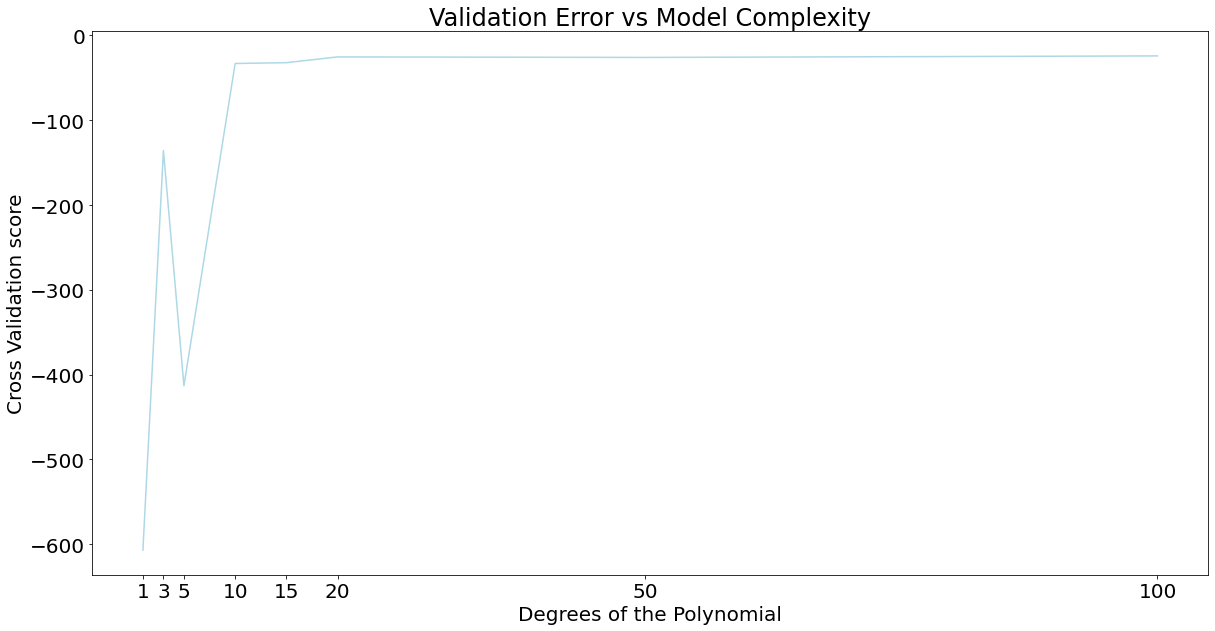

In [21]:
plt.figure(figsize = (20, 10))
plt.xticks(Degrees_considered)
plt.xlabel('Degrees of the Polynomial')
plt.ylabel('Cross Validation score')
plt.title('Validation Error vs Model Complexity')
plt.plot(Degrees_considered, cross_validation_scores, color='lightblue', label = 'Validation log-likelihood')

According to the plot, the model we would select based on Validation Log Likelihood would be the model with degree d = 10. With $\alpha$ = 10, we can see from the question 2 that the shape of the posterior predictive interval is very adequate to what we were seeking: a high lack of confidence from the model in the regions where it has been trained on poor amount of data and a low uncertainty in regions where the model has seen a lot of training data.  

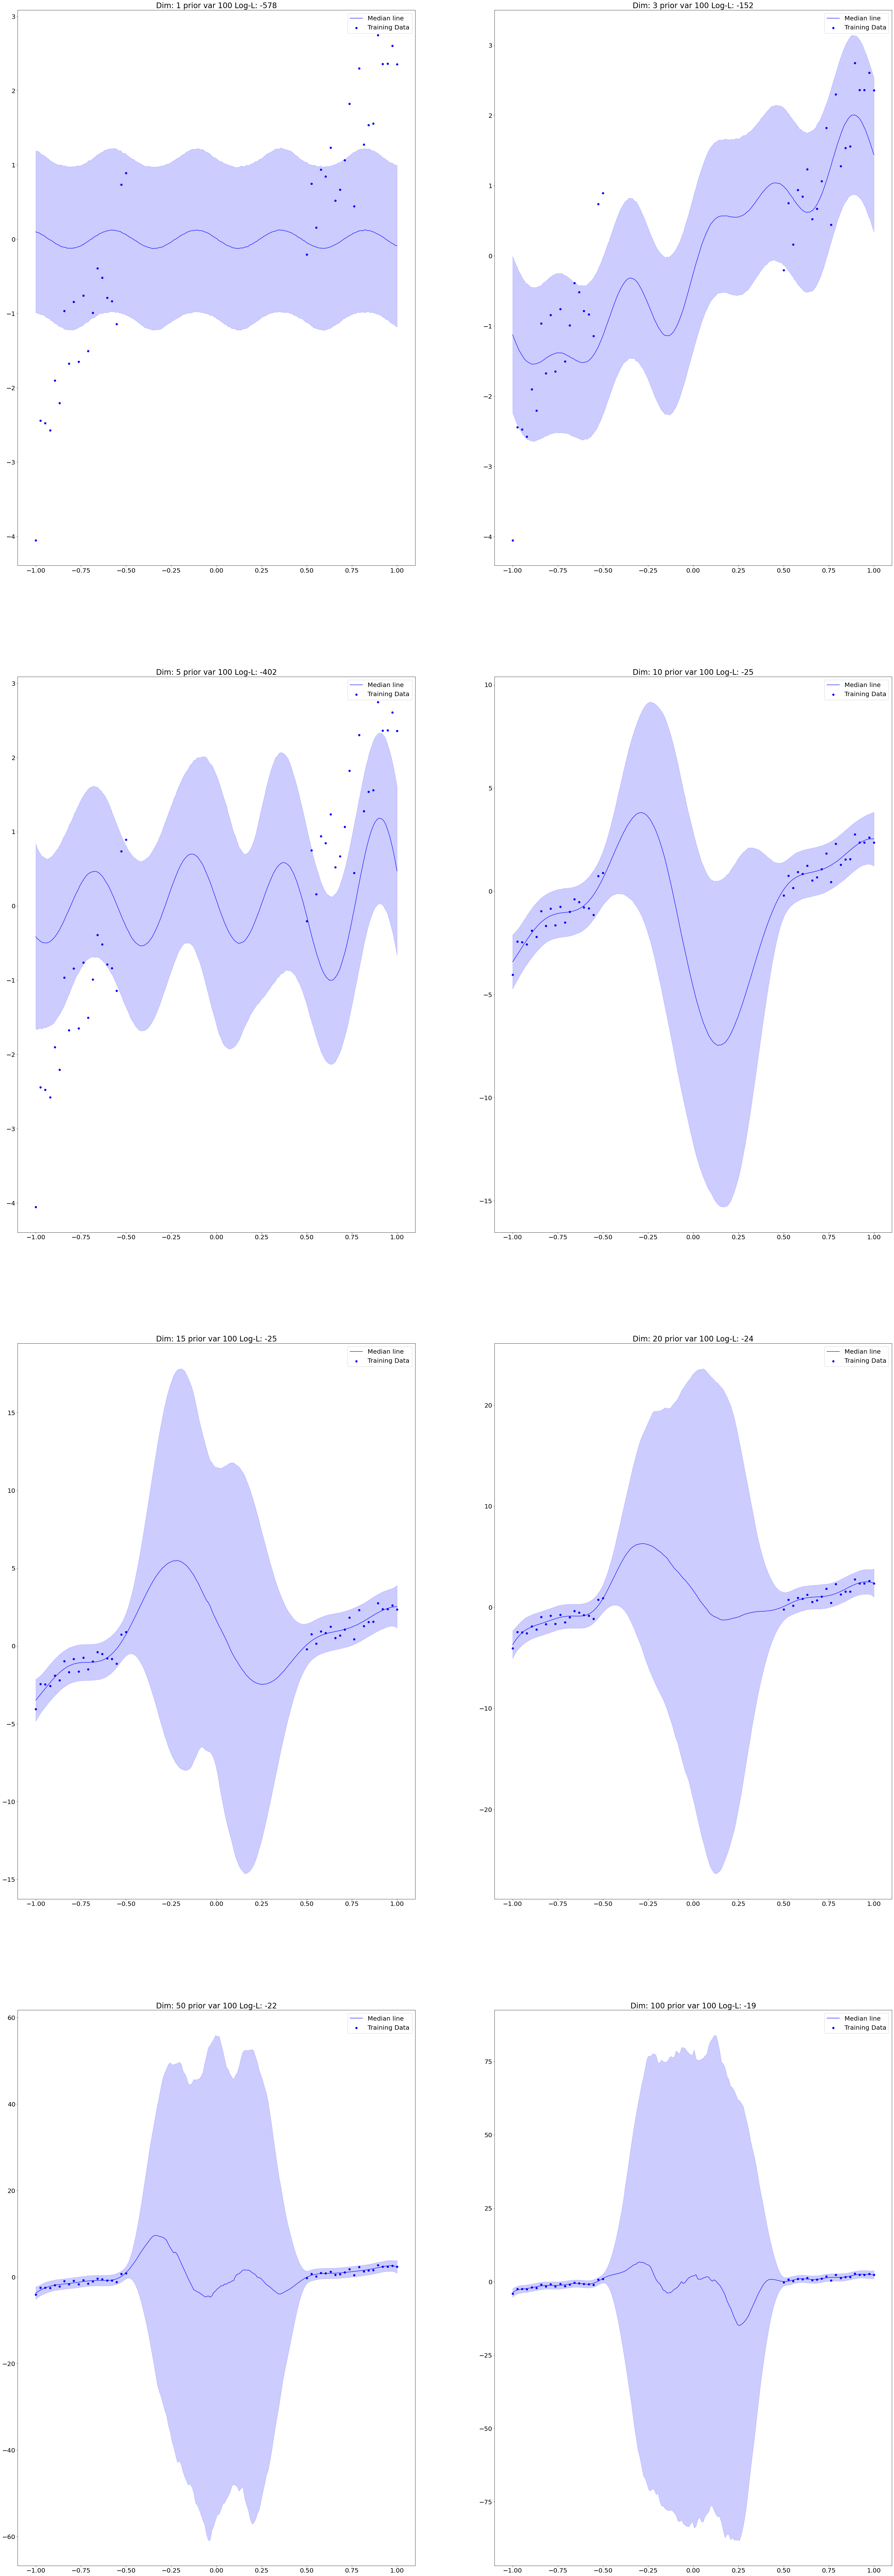

In [22]:
𝐷 = [1,3,5,10,15,20,50,100]
alpha = 100
fig, axes =  plt.subplots(4, 2, figsize=(50, 150))
plt.rcParams['font.size'] = 20
x_train, y_train, x_test = generate_data(number_of_points=20)
x_train_fit = x_train.reshape(-1, 1)
x_test_fit = x_test.reshape(-1, 1)
for i, d in enumerate(D):
    x_train_d = np.asarray([transformation_fourier(x, d) for x in x_train_fit])
    x_test_d = np.asarray([transformation_fourier(x, d) for x in x_test_fit])
    training_log_likelihood_score = get_marginal_likelihood(alpha, x_train_d,  y_train)
    posterior_predictions, posterior_predictive_samples = get_posterior_samples(alpha, 0.3, x_train_d, y_train, x_test_d, samples = 1000)
    y_pred_ub_pp_ft = np.percentile(posterior_predictive_samples, 97.5, axis=0)
    y_pred_median_pp_ft = np.percentile(posterior_predictive_samples, 50.0, axis=0)
    y_pred_lb_pp_ft = np.percentile(posterior_predictive_samples, 2.5, axis=0)
    model_prediction_d = np.asarray(model_prediction_d)
    axes[i//2, i%2].fill_between(x_test, y_pred_ub_pp_ft, y_pred_lb_pp_ft, color='blue', alpha=0.2)
    axes[i//2, i%2].plot(x_test, y_pred_median_pp_ft, color='blue', alpha=0.9, label = 'Median line')
    axes[i//2, i%2].scatter(x_train, y_train, color='blue', label='Training Data')
    axes[i//2, i%2].set_title('Dim: '+ str(d) +' prior var '+str(alpha) + ' Log-L: '+str(int(training_log_likelihood_score)))
    axes[i//2, i%2].legend()
plt.show()

I believe the Log-Likelihood based Cross-Validation process allowed to select a model that has a desirable predictive uncertainty shape.

## Part III: Comparisons and Conclusions

1. **(Bayesian versus Frequentist Uncertainty)** Compare the types of predictive uncertainties that are generated by Bayesian models and ensembles. Characterize the advantages and disadvantages of bootstrap uncertainties from an ensemble. Describe an application where it is better to compute bootstrap uncertainties rather than posterior predictive uncertainties from a Bayesian model (make your assumptions about these applications explicit).
<br><br> 
Characterize the advantages and disadvantages of posterior predictive uncertainties from a Bayesian model. Describe an application where it is better to use these uncertainties rather than bootstrap uncertainties from an ensemble.

For ensemble models, we have seen that the predictive uncertainties for regions with poor data are very high and quite overestimated for high complexity models. For Bayesian models, inserting a prior in this region with poor data allowed to counter this uncertainty effect and get more reliable predictive uncertainty in zones with poor data.

For the computation of uncertainties from bootstrap, several advantages and disadvantages appear:
- Advantages: Computationally convenient (for Bayesian models, we need to compute the integral), does not add any assumption on the model (the Bayesian adds a prior hypothesis)
- Disadvantages: Does not add any information on the training distribution since we always sample from the same distribution

An application where it would be more convenient to compute bootstrap uncertainties is a domain where no extensive and widespread prior knowledge would be accessible. Let's suppose that we define a model and the different priors we have tested yielded to very different results, implying that the prior has a very important influence on the posterior. Since we do not know which prior to use, computing bootstrap uncertainties might be a better option. 

For the posterior predictive uncertainties from a Bayesian Model:
- Advantages: Systematic approach, Allow to encapsulate prior domain knowledge into our model, uses a probabilistic approach rather than a frequentist approach. This enabled us here for instance to counter the effect of the missing data with the effect of the prior i  order to reduce the size of predictive uncertainties in the regions with poor data. 
- Disadvantages: Subjective prior, Computationnally difficult, Sometimes no closed form

An application where it would me more convenient to use posterior predictive uncertainties is tipically an application of covariate shift: the prior will enable us to get posterior predictive uncertainties way more realistic than using ensemble bootstraping. Another application would be when we do not have enough training examples. 

2. **(Measuring Uncertainty)** From your experiments, are any of the model evaluation metrics consdiered in this assignment (MSE, log-likelihood) appropriate for evaluating the quality of predictive uncertainty far away from the training data, that is, if we are concerned about the performance of models under covariate shift should we use these metrics to perform model selection?

I believe that all the metrics we have seen in this problem are quite off when trying to have a good understanding of what our generalization error would be in the case of covariate shift. Indeed, some metrics that would capture how 'robust' is our model in zones where we have not witnessed any data would be more adapted to understanding what would happen when deploying the model. 